<a href="https://colab.research.google.com/github/shreekar2005/Cheminformatics_DC/blob/main/DC2_NN_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import cudf
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [ ]:
# Load data into cudf (GPU DataFrame)
url1 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TRAIN_dense/tox21_dense_train.csv'
url2 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TRAIN_dense/tox21_labels_train.csv'
url3 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TEST_dense/tox21_dense_test.csv'
url4 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TEST_dense/tox21_labels_test.csv'

train_features = cudf.read_csv(url1)
train_labels = cudf.read_csv(url2)
test_features = cudf.read_csv(url3)
test_labels = cudf.read_csv(url4)

target_labels = ['NR.AhR', 'NR.AR', 'NR.AR.LBD', 'NR.Aromatase', 'NR.ER', 'NR.ER.LBD',
                 'NR.PPAR.gamma', 'SR.ARE', 'SR.ATAD5', 'SR.HSE', 'SR.MMP', 'SR.p53']

dense_features = train_features.select_dtypes(include=['float64', 'int64']).columns.tolist()
X_train = train_features[dense_features].to_cupy()
X_test = test_features[dense_features].to_cupy()

# Standardize features for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.get())
X_test = scaler.transform(X_test.get())

train_labels[target_labels] = train_labels[target_labels].fillna(0).clip(0, 1)
test_labels[target_labels] = test_labels[target_labels].fillna(0).clip(0, 1)

y_train = train_labels[target_labels].to_cupy()
y_test = test_labels[target_labels].to_cupy()

# Convert CuPy arrays to NumPy for PyTorch compatibility
y_train = y_train.get()
y_test = y_test.get()
X_train = X_train
X_test = X_test

# Convert NumPy arrays to PyTorch tensors
def to_tensor(array):
    return torch.tensor(array, dtype=torch.float32)

X_train_torch = to_tensor(X_train)
X_test_torch = to_tensor(X_test)
y_train_torch = to_tensor(y_train)
y_test_torch = to_tensor(y_test)

In [ ]:
print(X_train_torch.shape)
print(y_train_torch.shape)
print(X_test_torch.shape)
print(y_test_torch.shape)
# print(y_test_torch[3])

# Number of new samples
num_new_samples = 5000

# Get the number of existing samples
num_samples = X_train_torch.shape[0]

# Randomly select indices for triplets
idx1 = torch.randint(0, num_samples, (num_new_samples,))
idx2 = torch.randint(0, num_samples, (num_new_samples,))
idx3 = torch.randint(0, num_samples, (num_new_samples,))

# Compute new X by averaging features
X_new = (X_train_torch[idx1] + X_train_torch[idx2] + X_train_torch[idx3]) / 3.0

# Convert y to boolean before OR operation
y_new = (y_train_torch[idx1].bool() | y_train_torch[idx2].bool() | y_train_torch[idx3].bool()).float()

# Concatenate with the original dataset
X_train_torch_new = torch.cat([X_train_torch, X_new], dim=0)
y_train_torch_new = torch.cat([y_train_torch, y_new], dim=0)

# Print new shapes
print(X_train_torch_new.shape)
print(y_train_torch_new.shape)

# Create PyTorch DataLoader
def create_dataloader(X, y, batch_size=64, shuffle=True):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_train_torch, y_train_torch)
test_loader = create_dataloader(X_test_torch, y_test_torch, batch_size=32, shuffle=False)


torch.Size([12060, 801])
torch.Size([12060, 12])
torch.Size([647, 801])
torch.Size([647, 12])
torch.Size([17060, 801])
torch.Size([17060, 12])


In [ ]:
# Define Flexible Neural Network Class
class FlexibleNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=[512, 256], dropout_rate=0.2):
        super(FlexibleNN, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())  # Multi-label classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:
# Model initialization with flexibility
input_size = X_train.shape[1]
output_size = y_train.shape[1]

hidden_layers = [1024, 512, 256, 512, 256]  # Increased neurons to improve TPR
dropout_rate = 0.1  # Reduced dropout rate to retain more features

model = FlexibleNN(input_size, output_size, hidden_layers, dropout_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FlexibleNN(
  (model): Sequential(
    (0): Linear(in_features=801, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=512, out_features=256, bias=True)
    (17): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:

# Custom Weighted BCE Loss to Reduce False Negatives
class CustomBCELoss(nn.Module):
    def __init__(self, pos_weight=2.0):  # Increase weight for positives
        super(CustomBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

    def forward(self, outputs, targets):
        loss = self.bce(outputs, targets)
        return loss

# Define loss with higher positive weight
criterion = CustomBCELoss(pos_weight=10.0)  # Increase this if FN still exists
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    epoch_losses = []  # Store loss values for plotting
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot loss vs epochs
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs. Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/20, Loss: 0.9952
Epoch 2/20, Loss: 0.9692
Epoch 3/20, Loss: 0.9629
Epoch 4/20, Loss: 0.9611
Epoch 5/20, Loss: 0.9575
Epoch 6/20, Loss: 0.9545
Epoch 7/20, Loss: 0.9518
Epoch 8/20, Loss: 0.9492
Epoch 9/20, Loss: 0.9484
Epoch 10/20, Loss: 0.9477
Epoch 11/20, Loss: 0.9458
Epoch 12/20, Loss: 0.9448
Epoch 13/20, Loss: 0.9433
Epoch 14/20, Loss: 0.9414
Epoch 15/20, Loss: 0.9398
Epoch 16/20, Loss: 0.9408
Epoch 17/20, Loss: 0.9401
Epoch 18/20, Loss: 0.9379
Epoch 19/20, Loss: 0.9377
Epoch 20/20, Loss: 0.9355


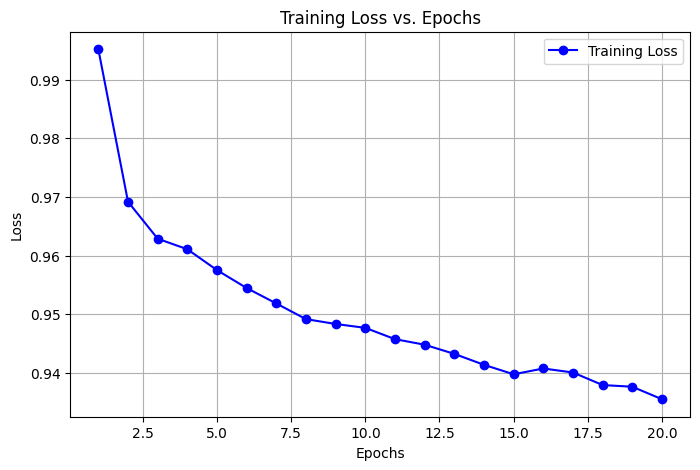

In [ ]:
# Training
train_model(model, train_loader, criterion, optimizer, epochs=20)

[5.0081001e-03 4.6451321e-01 4.2431298e-01 1.7823534e-03 4.0837680e-03
 6.2941996e-05 8.1172830e-04 2.3888560e-01 4.9236078e-05 3.3433147e-04
 9.1178519e-01 1.0032052e-01]


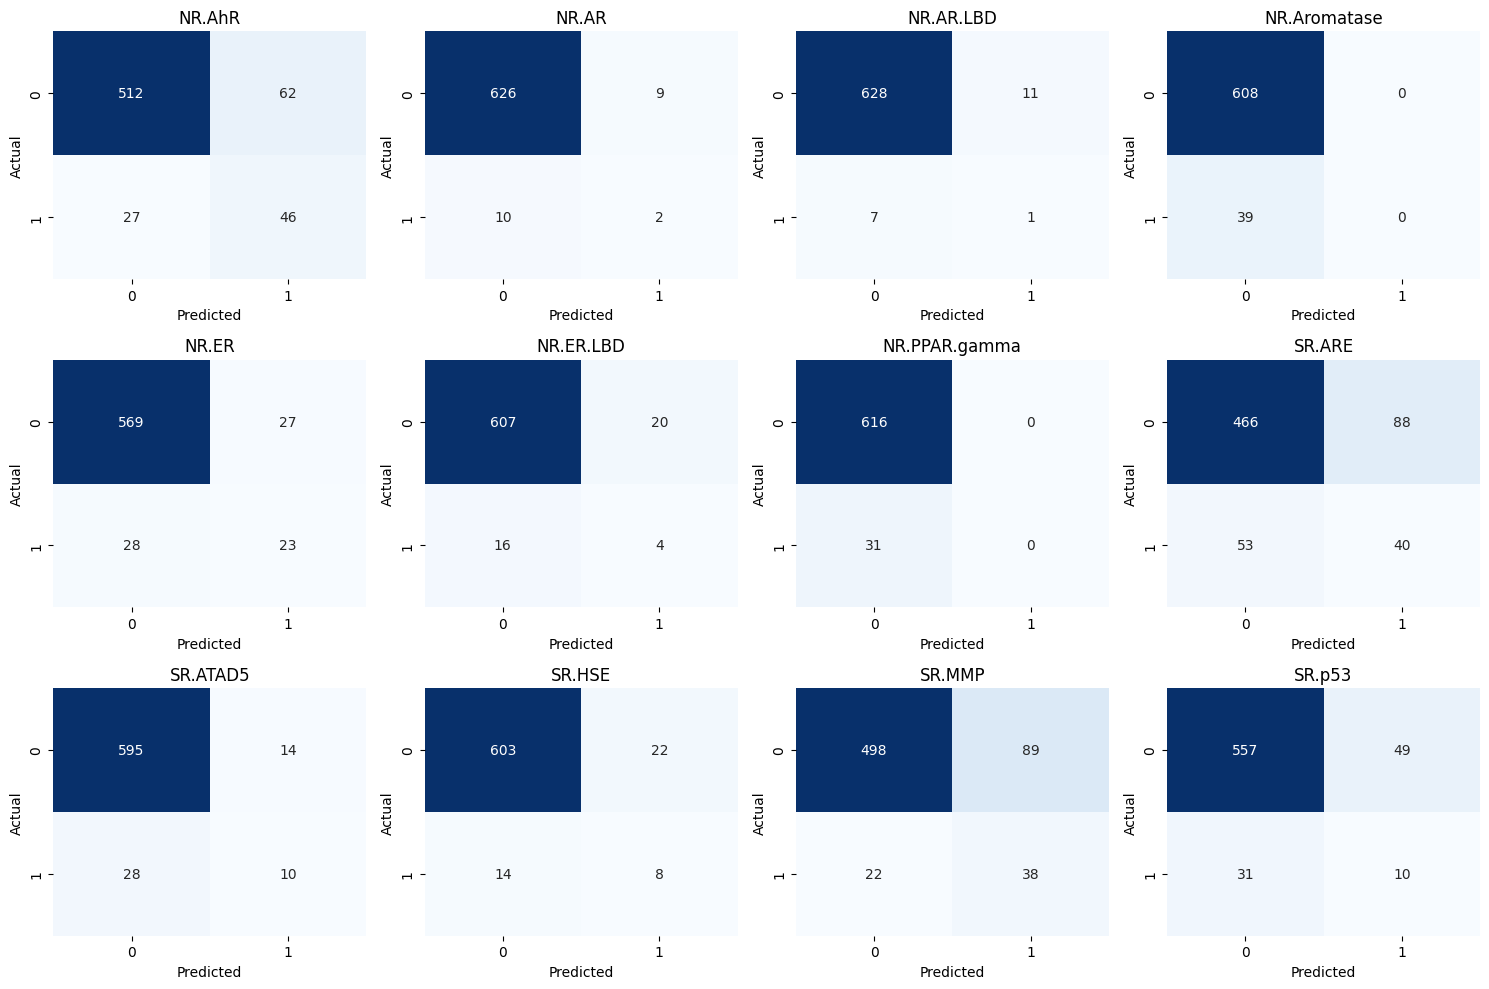

               precision    recall  f1-score   support

       NR.AhR       0.43      0.63      0.51        73
        NR.AR       0.18      0.17      0.17        12
    NR.AR.LBD       0.08      0.12      0.10         8
 NR.Aromatase       0.00      0.00      0.00        39
        NR.ER       0.46      0.45      0.46        51
    NR.ER.LBD       0.17      0.20      0.18        20
NR.PPAR.gamma       0.00      0.00      0.00        31
       SR.ARE       0.31      0.43      0.36        93
     SR.ATAD5       0.42      0.26      0.32        38
       SR.HSE       0.27      0.36      0.31        22
       SR.MMP       0.30      0.63      0.41        60
       SR.p53       0.17      0.24      0.20        41

    micro avg       0.32      0.37      0.34       488
    macro avg       0.23      0.29      0.25       488
 weighted avg       0.28      0.37      0.31       488
  samples avg       0.09      0.11      0.09       488



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).cpu().numpy()
            all_preds.append(outputs)
            all_labels.append(y_batch.numpy())
    return np.vstack(all_preds), np.vstack(all_labels)

# Get predictions
preds, labels = evaluate_model(model, test_loader)

# **Important: Adjust threshold to prioritize True Positives**
threshold = 0.5  # Reduce threshold to capture more positives
print(preds[0])
preds = (preds > threshold).astype(int)


# Compute multi-label confusion matrices
conf_matrices = multilabel_confusion_matrix(labels, preds)

# Plot confusion matrices for each label
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 labels
axes = axes.flatten()

for i, (ax, label) in enumerate(zip(axes, target_labels)):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(label)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Print detailed metrics
print(classification_report(labels, preds, target_names=target_labels))